### Keras & TensorFlow to Predict Market Movements and Backtesting

In [74]:
#!pip install pyfolio
#!pip install backtrader
# conda install -c conda-forge ta-lib # run at anaconda prompt
# may ignore zipline.assets not found issue.
# Coding References from https://medium.com/analytics-vidhya/keras-tensorflow-to-predict-market-movements-and-backtest-using-backtrader-d51b0b3e9070
# make the necessary imports 
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import yfinance as yf
import warnings
import datetime
import pyfolio as pf
import backtrader as bt
from backtrader.feeds import PandasData
import warnings
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import Dense, Dropout
from keras.models import Sequential
from talib import RSI, BBANDS, MACD

# set the style and ignore warnings
plt.style.use('seaborn-colorblind')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [75]:
# this is to display images in notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Data Gathering

In [76]:
# ticker and the start and end dates for testing
ticker =  'INTC' 
start = datetime.datetime(2012, 1, 1)
end = datetime.datetime(2022, 3, 2)

In [77]:
# download ticker stock price from yahoo finance
stock =  yf.download(ticker, progress=True, actions=True,start=start, end=end)['Adj Close']
stock = pd.DataFrame(stock)
stock.rename(columns = {'Adj Close':'close'}, inplace=True)
stock.head(2)

[*********************100%***********************]  1 of 1 completed


,close
Date,
2012-01-03,18.147917
2012-01-04,18.569448


In [78]:
#stock.to_csv('INTC.csv')

In [79]:
# #stock = pd.read_csv('NSEI.csv', parse_dates=[0])
# stock = pd.read_csv('NSEI.csv', header=None, sep=",", index_col=[0],  parse_dates=[0])
# stock = stock.apply(pd.to_numeric, errors='coerce')
# stock.info

In [80]:
# calculate daily log returns and market direction
stock['returns'] = np.log(stock / stock.shift(1))
#stock['returns'] = stock / stock.shift(1)
stock.dropna(inplace=True)
stock['direction'] = np.sign(stock['returns']).astype(int)
stock.head(3)

,close,returns,direction
Date,,,
2012-01-04,18.569448,0.022962,1
2012-01-05,18.783903,0.011483,1
2012-01-06,18.672983,-0.005923,-1


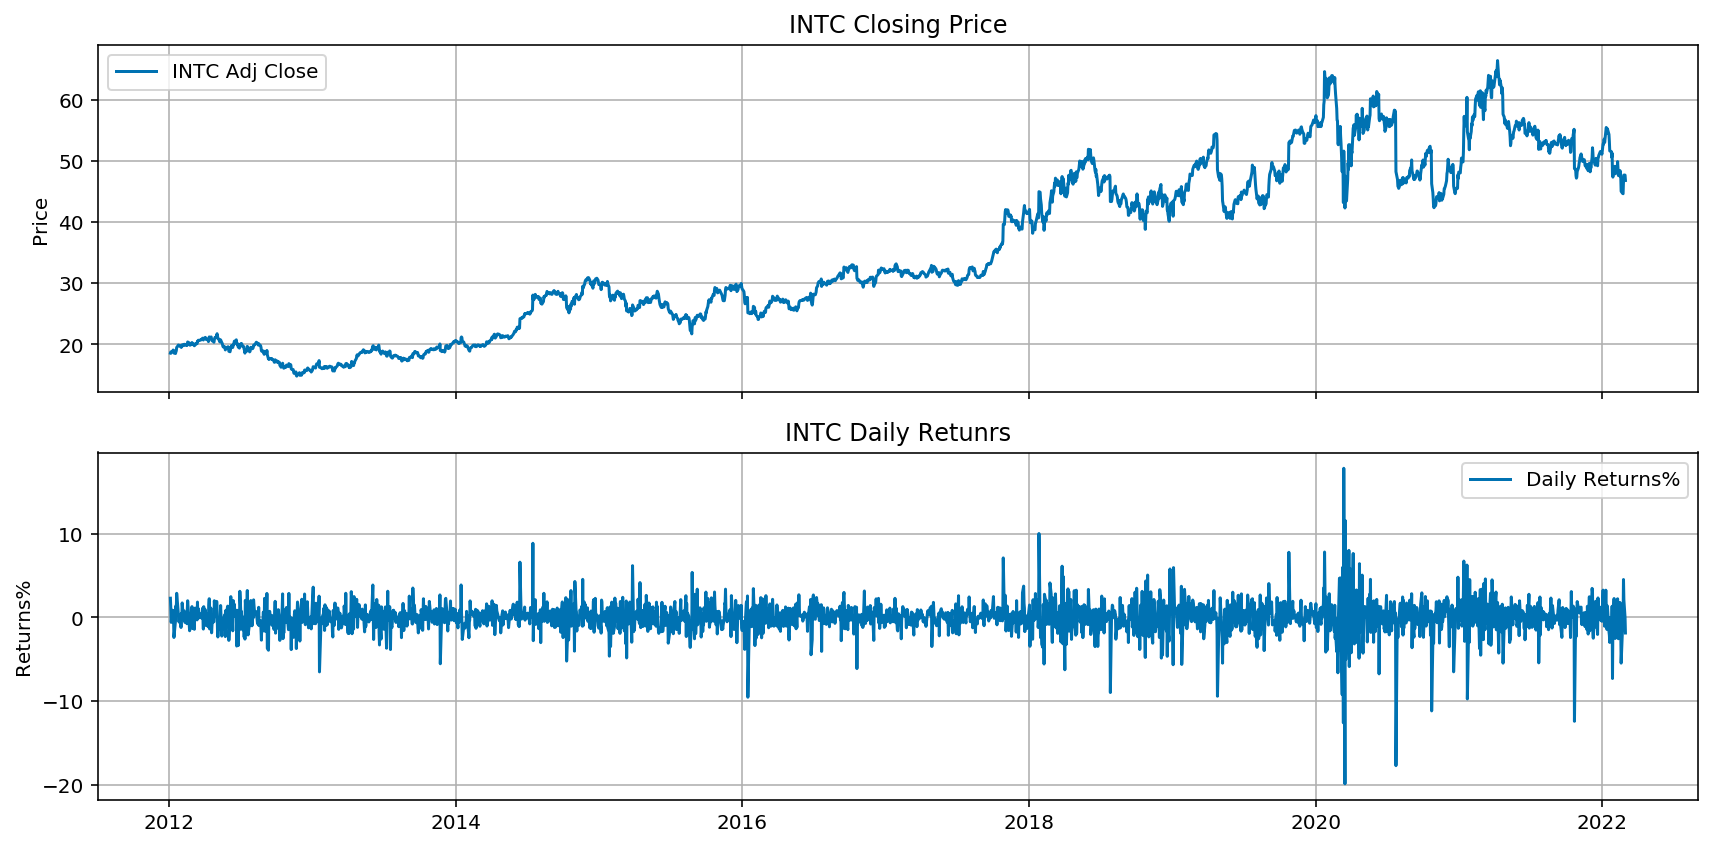

In [81]:
# visualize the closing price and daily returns
fig, ax = plt.subplots(2, 1, sharex=True, figsize = (12,6))
ax[0].plot(stock.close, label = f'{ticker} Adj Close')
ax[0].set(title = f'{ticker} Closing Price', ylabel = 'Price')
ax[0].grid(True)
ax[0].legend()

ax[1].plot(stock['returns']*100, label = 'Daily Returns%')
ax[1].set(title = f'{ticker} Daily Retunrs', ylabel = 'Returns%')
ax[1].grid(True)
plt.legend()

plt.tight_layout();
plt.savefig('images/chart1', dpi=300)

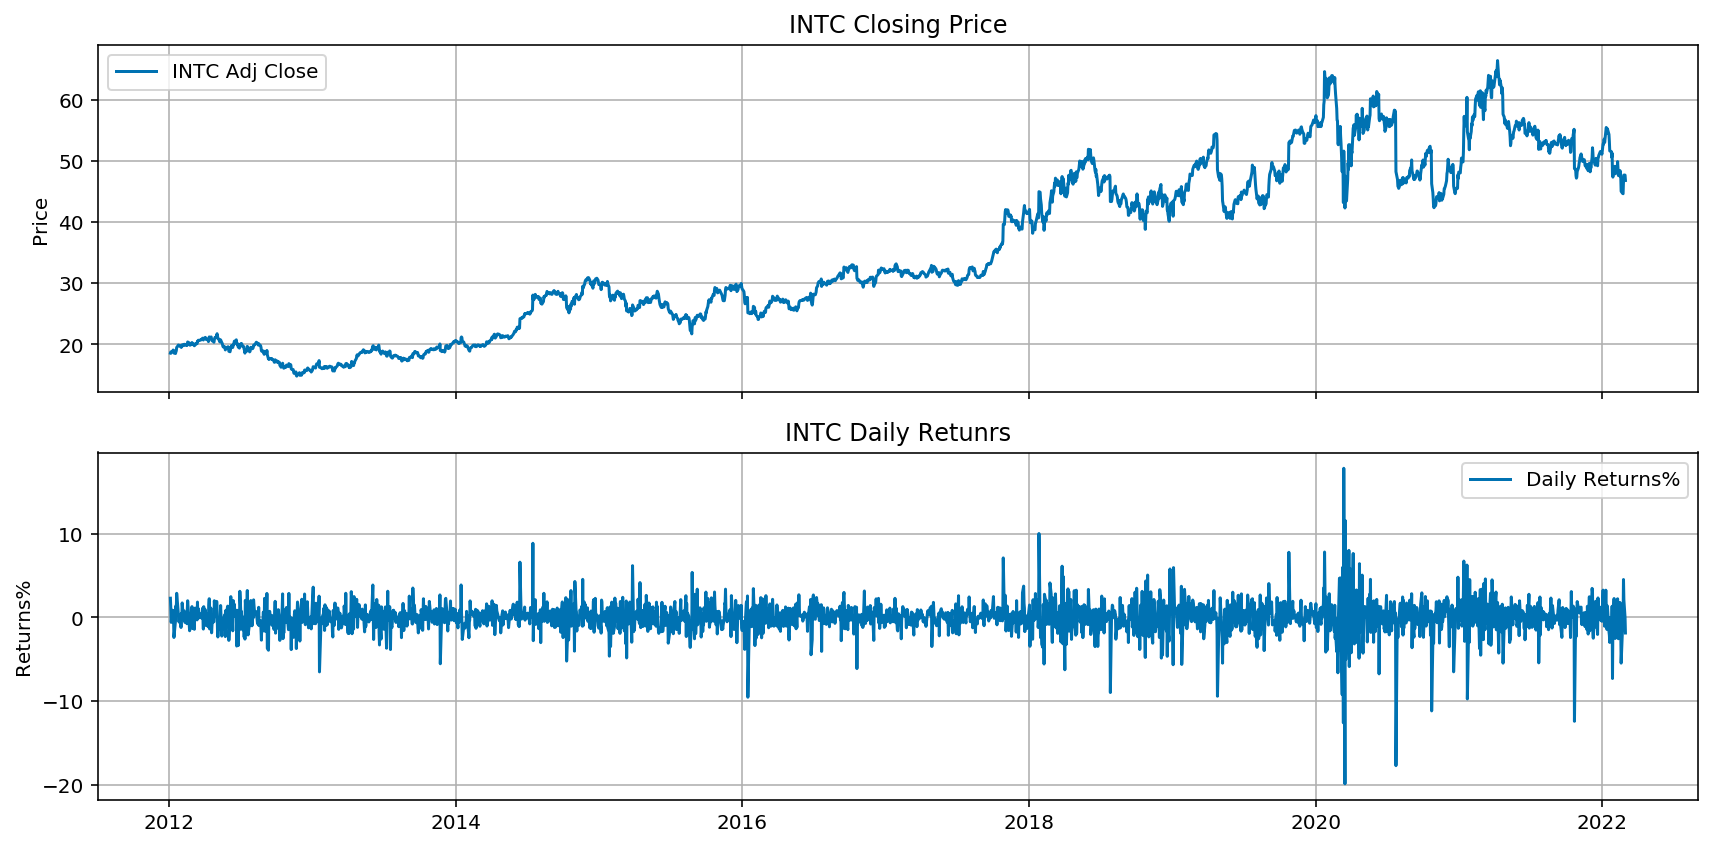

In [82]:
#plt.axis([2200, 2500, 40, 70])

# visualize the closing price and daily returns
fig, ax = plt.subplots(2, 1, sharex=True, figsize = (12,6))
ax[0].plot(stock.close, label = f'{ticker} Adj Close')
ax[0].set(title = f'{ticker} Closing Price', ylabel = 'Price')
ax[0].grid(True)
ax[0].legend()

ax[1].plot(stock['returns']*100, label = 'Daily Returns%')
ax[1].set(title = f'{ticker} Daily Retunrs', ylabel = 'Returns%')
ax[1].grid(True)
plt.legend()

plt.tight_layout();
plt.savefig('images/chart1', dpi=300)

In [83]:
stock['returns'].expanding().std()

Date
2012-01-04         NaN
2012-01-05    0.008117
2012-01-06    0.014543
2012-01-09    0.011882
2012-01-10    0.010493
                ...   
2022-02-23    0.018495
2022-02-24    0.018512
2022-02-25    0.018513
2022-02-28    0.018510
2022-03-01    0.018510
Name: returns, Length: 2556, dtype: float64

### Feature Engineering

In [84]:
# define the number of lags
lags = [1, 2, 3, 4, 5]

In [85]:
# compute lagged log returns
cols = []
for lag in lags:
    col = f'rtn_lag{lag}'
    stock[col] = stock['returns'].shift(lag)
    cols.append(col)
stock.head(5)

,close,returns,direction,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5
Date,,,,,,,,
2012-01-04,18.569448,0.022962,1,NaN,NaN,NaN,NaN,NaN
2012-01-05,18.783903,0.011483,1,0.022962,NaN,NaN,NaN,NaN
2012-01-06,18.672983,-0.005923,-1,0.011483,0.022962,NaN,NaN,NaN
2012-01-09,18.835670,0.008675,1,-0.005923,0.011483,0.022962,NaN,NaN
2012-01-10,18.924419,0.004701,1,0.008675,-0.005923,0.011483,0.022962,NaN


In [86]:
# RSI - Relative Strenght Index
stock['rsi'] = RSI(stock.close)

# append to feature columns list
cols.append('rsi')
stock.tail(2)

,close,returns,direction,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5,rsi
Date,,,,,,,,,
2022-02-28,47.700001,-0.000210,-1,0.020969,0.045318,-0.000895,-0.007801,-0.054651,47.035678
2022-03-01,46.820000,-0.018621,-1,-0.000210,0.020969,0.045318,-0.000895,-0.007801,43.347874


In [87]:
# Compute Bollinger Bands
high, mid, low = BBANDS(stock.close, timeperiod=20)
stock = stock.join(pd.DataFrame({'bb_high': high, 'bb_low': low}, index=stock.index))

# append to feature columns list
cols.append('bb_high')
cols.append('bb_low')

In [88]:
# Compute Moving Average Convergence/ Divergence
stock['macd'] = MACD(stock.close)[0]

# append to feature columns list
cols.append('macd')

In [89]:
cols

['rtn_lag1',
 'rtn_lag2',
 'rtn_lag3',
 'rtn_lag4',
 'rtn_lag5',
 'rsi',
 'bb_high',
 'bb_low',
 'macd']

In [90]:
# # let's look at the head and tail of our dataframe
stock.head().append(stock.tail())

,close,returns,direction,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5,rsi,bb_high,bb_low,macd
Date,,,,,,,,,,,,
2012-01-04,18.569448,0.022962,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-05,18.783903,0.011483,1,0.022962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-06,18.672983,-0.005923,-1,0.011483,0.022962,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-09,18.835670,0.008675,1,-0.005923,0.011483,0.022962,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-10,18.924419,0.004701,1,0.008675,-0.005923,0.011483,0.022962,NaN,NaN,NaN,NaN,NaN
2022-02-23,44.650002,-0.000895,-1,-0.007801,-0.054651,-0.013779,-0.004345,0.017913,30.092660,51.057339,44.746327,-1.445954
2022-02-24,46.720001,0.045318,1,-0.000895,-0.007801,-0.054651,-0.013779,-0.004345,42.313085,50.451078,44.894667,-1.363131
2022-02-25,47.709999,0.020969,1,0.045318,-0.000895,-0.007801,-0.054651,-0.013779,47.077933,50.452283,44.895788,-1.203732
2022-02-28,47.700001,-0.000210,-1,0.020969,0.045318,-0.000895,-0.007801,-0.054651,47.035678,50.465304,44.915851,-1.065927


### Build and Apply the Model

In [91]:
len(cols)

9

In [92]:
# split the dataset in training and test datasets
train, test = train_test_split(stock.dropna(), test_size=0.4, shuffle=False)

# sort the data on date index
train = train.copy().sort_index()
test = test.copy().sort_index()

In [93]:
# # view train dataset
train.tail(10)

,close,returns,direction,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5,rsi,bb_high,bb_low,macd
Date,,,,,,,,,,,,
2018-02-12,40.544300,0.019825,1,0.027683,-0.055728,0.006437,0.015483,-0.035958,48.366550,44.782273,37.673631,-0.091830
2018-02-13,40.209671,-0.008288,-1,0.019825,0.027683,-0.055728,0.006437,0.015483,46.962017,44.705819,37.895756,-0.134276
2018-02-14,41.041729,0.020482,1,-0.008288,0.019825,0.027683,-0.055728,0.006437,50.788731,44.703925,38.014241,-0.099627
2018-02-15,41.530098,0.011829,1,0.020482,-0.008288,0.019825,0.027683,-0.055728,52.935153,44.720392,38.155115,-0.032386
2018-02-16,41.204517,-0.007871,-1,0.011829,0.020482,-0.008288,0.019825,0.027683,51.327847,44.725443,38.244304,-0.005307
2018-02-20,41.891853,0.016543,1,-0.007871,0.011829,0.020482,-0.008288,0.019825,54.470811,44.764667,38.284513,0.070799
2018-02-21,41.548180,-0.008238,-1,0.016543,-0.007871,0.011829,0.020482,-0.008288,52.640435,44.772565,38.293831,0.102203
2018-02-22,41.421566,-0.003052,-1,-0.008238,0.016543,-0.007871,0.011829,0.020482,51.947866,44.786362,38.333998,0.115543
2018-02-23,43.167065,0.041276,1,-0.003052,-0.008238,0.016543,-0.007871,0.011829,59.800086,44.956967,38.410771,0.263920


In [94]:
test.head()

,close,returns,direction,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5,rsi,bb_high,bb_low,macd
Date,,,,,,,,,,,,
2018-02-27,45.138660,0.016159,1,0.028503,0.041276,-0.003052,-0.008238,0.016543,66.622085,44.883455,38.451206,0.695734
2018-02-28,44.577927,-0.012500,-1,0.016159,0.028503,0.041276,-0.003052,-0.008238,63.182531,45.036190,38.373424,0.814664
2018-03-01,43.266552,-0.029859,-1,-0.012500,0.016159,0.028503,0.041276,-0.003052,55.912333,45.039346,38.372475,0.793948
2018-03-02,44.297573,0.023550,1,-0.029859,-0.012500,0.016159,0.028503,0.041276,59.826295,45.272212,38.288935,0.850916
2018-03-05,44.993954,0.015598,1,0.023550,-0.029859,-0.012500,0.016159,0.028503,62.263146,45.713841,38.201016,0.941404


In [95]:
# # view test dataset
test.tail()

,close,returns,direction,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5,rsi,bb_high,bb_low,macd
Date,,,,,,,,,,,,
2022-02-23,44.650002,-0.000895,-1,-0.007801,-0.054651,-0.013779,-0.004345,0.017913,30.092660,51.057339,44.746327,-1.445954
2022-02-24,46.720001,0.045318,1,-0.000895,-0.007801,-0.054651,-0.013779,-0.004345,42.313085,50.451078,44.894667,-1.363131
2022-02-25,47.709999,0.020969,1,0.045318,-0.000895,-0.007801,-0.054651,-0.013779,47.077933,50.452283,44.895788,-1.203732
2022-02-28,47.700001,-0.000210,-1,0.020969,0.045318,-0.000895,-0.007801,-0.054651,47.035678,50.465304,44.915851,-1.065927
2022-03-01,46.820000,-0.018621,-1,-0.000210,0.020969,0.045318,-0.000895,-0.007801,43.347874,50.385445,44.832619,-1.016012


To know more about keras and TF, please refer to https://keras.io/

In [96]:
# define a function to create the deep neural network model
def create_model():
    np.random.seed(100)
    tf.random.set_seed(100)
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=len(cols)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', #'rmsprop', 
                  metrics=['accuracy'])
    return model

In [97]:
# normalized the training dataset
mu, std = train.mean(), train.std()
train_ = (train - mu) / mu.std()

In [98]:
train

,close,returns,direction,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5,rsi,bb_high,bb_low,macd
Date,,,,,,,,,,,,
2012-02-22,19.925432,-0.015959,-1,-0.007702,0.019927,0.009361,-0.007496,0.002992,56.893112,20.286481,19.501841,0.311807
2012-02-23,19.873255,-0.002622,-1,-0.015959,-0.007702,0.019927,0.009361,-0.007496,55.514778,20.285590,19.500739,0.279571
2012-02-24,19.903070,0.001499,1,-0.002622,-0.015959,-0.007702,0.019927,0.009361,56.168255,20.288321,19.510087,0.253508
2012-02-27,20.044706,0.007091,1,0.001499,-0.002622,-0.015959,-0.007702,0.019927,59.231964,20.302177,19.523956,0.241498
2012-02-28,20.305611,0.012932,1,0.007091,0.001499,-0.002622,-0.015959,-0.007702,64.196483,20.358636,19.520569,0.250149
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-20,41.891853,0.016543,1,-0.007871,0.011829,0.020482,-0.008288,0.019825,54.470811,44.764667,38.284513,0.070799
2018-02-21,41.548180,-0.008238,-1,0.016543,-0.007871,0.011829,0.020482,-0.008288,52.640435,44.772565,38.293831,0.102203
2018-02-22,41.421566,-0.003052,-1,-0.008238,0.016543,-0.007871,0.011829,0.020482,51.947866,44.786362,38.333998,0.115543


In [99]:
mu.std()

17.56724207585391

In [100]:
mu

close        25.616441
returns       0.000519
direction     0.062789
rtn_lag1      0.000495
rtn_lag2      0.000481
rtn_lag3      0.000489
rtn_lag4      0.000490
rtn_lag5      0.000481
rsi          53.366144
bb_high      26.644190
bb_low       24.317532
macd          0.100456
dtype: float64

In [101]:
std

close         6.469404
returns       0.014044
direction     0.992377
rtn_lag1      0.014027
rtn_lag2      0.013997
rtn_lag3      0.013998
rtn_lag4      0.013998
rtn_lag5      0.013992
rsi          12.689925
bb_high       6.737308
bb_low        5.965410
macd          0.408524
dtype: float64

In [102]:
train_

,close,returns,direction,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5,rsi,bb_high,bb_low,macd
Date,,,,,,,,,,,,
2012-02-22,-0.323956,-0.000938,-0.060498,-0.000467,0.001107,0.000505,-0.000455,0.000143,0.200770,-0.361907,-0.274129,0.012031
2012-02-23,-0.326926,-0.000179,-0.060498,-0.000937,-0.000466,0.001106,0.000505,-0.000454,0.122309,-0.361958,-0.274192,0.010196
2012-02-24,-0.325229,0.000056,0.053350,-0.000177,-0.000936,-0.000466,0.001106,0.000506,0.159508,-0.361802,-0.273660,0.008712
2012-02-27,-0.317166,0.000374,0.053350,0.000057,-0.000177,-0.000936,-0.000466,0.001107,0.333907,-0.361014,-0.272870,0.008029
2012-02-28,-0.302314,0.000707,0.053350,0.000375,0.000058,-0.000177,-0.000936,-0.000466,0.616508,-0.357800,-0.273063,0.008521
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-20,0.926464,0.000912,0.053350,-0.000476,0.000646,0.001138,-0.000500,0.001101,0.062882,1.031492,0.795058,-0.001688
2018-02-21,0.906900,-0.000498,-0.060498,0.000914,-0.000475,0.000646,0.001138,-0.000499,-0.041310,1.031942,0.795589,0.000099
2018-02-22,0.899693,-0.000203,-0.060498,-0.000497,0.000914,-0.000476,0.000645,0.001139,-0.080734,1.032727,0.797875,0.000859


In [103]:
# create the model
model = create_model()

In [104]:
# map market direction of (1,-1) to (1,0)
train['direction_'] = np.where(train['direction'] > 0, 1, 0)

In [105]:
cols

['rtn_lag1',
 'rtn_lag2',
 'rtn_lag3',
 'rtn_lag4',
 'rtn_lag5',
 'rsi',
 'bb_high',
 'bb_low',
 'macd']

In [106]:
train_.head()

,close,returns,direction,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5,rsi,bb_high,bb_low,macd
Date,,,,,,,,,,,,
2012-02-22,-0.323956,-0.000938,-0.060498,-0.000467,0.001107,0.000505,-0.000455,0.000143,0.200770,-0.361907,-0.274129,0.012031
2012-02-23,-0.326926,-0.000179,-0.060498,-0.000937,-0.000466,0.001106,0.000505,-0.000454,0.122309,-0.361958,-0.274192,0.010196
2012-02-24,-0.325229,0.000056,0.053350,-0.000177,-0.000936,-0.000466,0.001106,0.000506,0.159508,-0.361802,-0.273660,0.008712
2012-02-27,-0.317166,0.000374,0.053350,0.000057,-0.000177,-0.000936,-0.000466,0.001107,0.333907,-0.361014,-0.272870,0.008029
2012-02-28,-0.302314,0.000707,0.053350,0.000375,0.000058,-0.000177,-0.000936,-0.000466,0.616508,-0.357800,-0.273063,0.008521


In [107]:
train_[cols]

,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5,rsi,bb_high,bb_low,macd
Date,,,,,,,,,
2012-02-22,-0.000467,0.001107,0.000505,-0.000455,0.000143,0.200770,-0.361907,-0.274129,0.012031
2012-02-23,-0.000937,-0.000466,0.001106,0.000505,-0.000454,0.122309,-0.361958,-0.274192,0.010196
2012-02-24,-0.000177,-0.000936,-0.000466,0.001106,0.000506,0.159508,-0.361802,-0.273660,0.008712
2012-02-27,0.000057,-0.000177,-0.000936,-0.000466,0.001107,0.333907,-0.361014,-0.272870,0.008029
2012-02-28,0.000375,0.000058,-0.000177,-0.000936,-0.000466,0.616508,-0.357800,-0.273063,0.008521
...,...,...,...,...,...,...,...,...,...
2018-02-20,-0.000476,0.000646,0.001138,-0.000500,0.001101,0.062882,1.031492,0.795058,-0.001688
2018-02-21,0.000914,-0.000475,0.000646,0.001138,-0.000499,-0.041310,1.031942,0.795589,0.000099
2018-02-22,-0.000497,0.000914,-0.000476,0.000645,0.001139,-0.080734,1.032727,0.797875,0.000859


In [108]:
train['direction_']

Date
2012-02-22    0
2012-02-23    0
2012-02-24    1
2012-02-27    1
2012-02-28    1
             ..
2018-02-20    1
2018-02-21    0
2018-02-22    0
2018-02-23    1
2018-02-26    1
Name: direction_, Length: 1513, dtype: int32

In [109]:
%%time
# fit the model for training dataset
r = model.fit(train_[cols], train['direction_'], epochs=50, verbose=False)

Wall time: 2.53 s


In [110]:
# normalized the test dataset
mu, std = test.mean(), test.std()
test_ = (test - mu) / std

In [111]:
# map market direction of (1,-1) to (1,0)
test['direction_'] = np.where(test['direction'] > 0, 1, 0)

In [112]:
# evaluate the model with test dataset
model.evaluate(test_[cols], test['direction_'])

32/32 [==============================] - 0s 1ms/step - loss: 56.8438 - accuracy: 0.4861


[56.84380340576172, 0.48613861203193665]

In [113]:
# predict the direction and map it (1,0)
pred = np.where(model.predict(test_[cols]) > 0.5, 1, 0) 
pred[:10].flatten()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [114]:
# based on prediction calculate the position for strategy
test['position_strategy'] = np.where(pred > 0, 1, -1)
#test['position_strategy'] = np.where(pred > 0, -1, 1)  # adjust this for backtrade. 

In [115]:
# calculate daily returns for the strategy
test['strategy_return'] = test['position_strategy'] * test['returns']

In [116]:
test.head()

,close,returns,direction,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5,rsi,bb_high,bb_low,macd,direction_,position_strategy,strategy_return
Date,,,,,,,,,,,,,,,
2018-02-27,45.138660,0.016159,1,0.028503,0.041276,-0.003052,-0.008238,0.016543,66.622085,44.883455,38.451206,0.695734,1,-1,-0.016159
2018-02-28,44.577927,-0.012500,-1,0.016159,0.028503,0.041276,-0.003052,-0.008238,63.182531,45.036190,38.373424,0.814664,0,-1,0.012500
2018-03-01,43.266552,-0.029859,-1,-0.012500,0.016159,0.028503,0.041276,-0.003052,55.912333,45.039346,38.372475,0.793948,0,-1,0.029859
2018-03-02,44.297573,0.023550,1,-0.029859,-0.012500,0.016159,0.028503,0.041276,59.826295,45.272212,38.288935,0.850916,1,-1,-0.023550
2018-03-05,44.993954,0.015598,1,0.023550,-0.029859,-0.012500,0.016159,0.028503,62.263146,45.713841,38.201016,0.941404,1,-1,-0.015598


In [117]:
test.to_csv('INTC_test.csv')

In [118]:
# calculate total return and std. deviation of each strategy
print('\nTotal Returns:')
print(test[['returns', 'strategy_return']].sum().apply(np.exp))
print('\nAnnual Volatility:')
print(test[['returns', 'strategy_return']].std() * 252 ** 0.5)


Total Returns:
returns            1.054145
strategy_return    1.649000
dtype: float64

Annual Volatility:
returns            0.378333
strategy_return    0.378252
dtype: float64


In [119]:
# number of trades over time for the strategy
print('Number of trades = ', (test['position_strategy'].diff()!=0).sum())

Number of trades =  199


In [120]:
test.returns.head

<bound method NDFrame.head of Date
2018-02-27    0.016159
2018-02-28   -0.012500
2018-03-01   -0.029859
2018-03-02    0.023550
2018-03-05    0.015598
                ...   
2022-02-23   -0.000895
2022-02-24    0.045318
2022-02-25    0.020969
2022-02-28   -0.000210
2022-03-01   -0.018621
Name: returns, Length: 1010, dtype: float64>

In [121]:
test.returns.cumsum().apply(np.exp)


Date
2018-02-27    1.016290
2018-02-28    1.003665
2018-03-01    0.974140
2018-03-02    0.997353
2018-03-05    1.013032
                ...   
2022-02-23    1.005288
2022-02-24    1.051894
2022-02-25    1.074183
2022-02-28    1.073958
2022-03-01    1.054145
Name: returns, Length: 1010, dtype: float64

In [122]:
test.strategy_return.cumsum().apply(np.exp)

Date
2018-02-27    0.983971
2018-02-28    0.996348
2018-03-01    1.026547
2018-03-02    1.002654
2018-03-05    0.987136
                ...   
2022-02-23    1.514450
2022-02-24    1.584660
2022-02-25    1.618239
2022-02-28    1.618579
2022-03-01    1.649000
Name: strategy_return, Length: 1010, dtype: float64

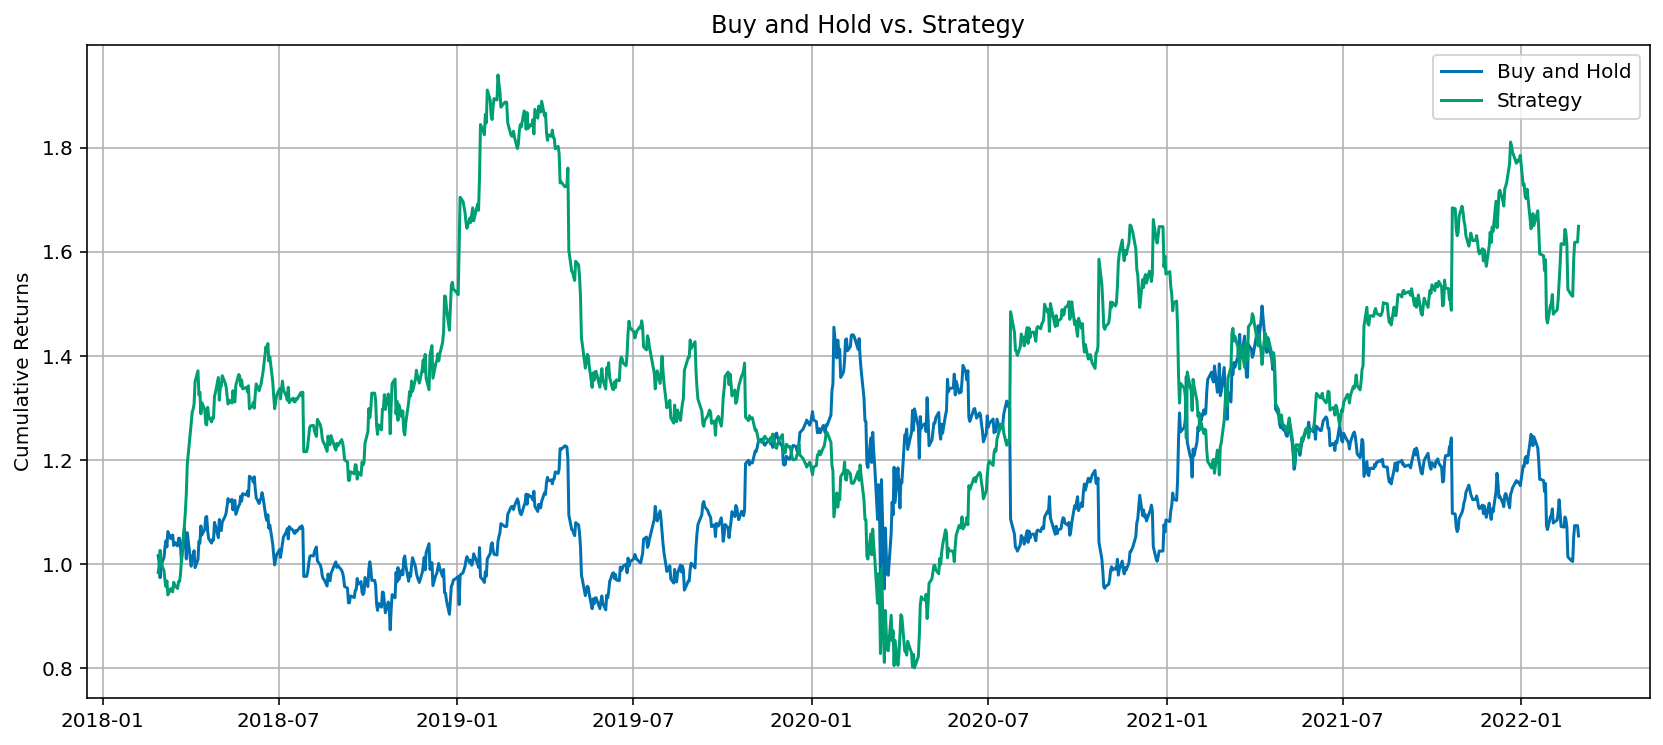

In [123]:
# plot cumulative returns
fig, ax = plt.subplots(1, 1, sharex=True, figsize = (14,6))
ax.plot(test.returns.cumsum().apply(np.exp), label = 'Buy and Hold')
ax.plot(test.strategy_return.cumsum().apply(np.exp), label = 'Strategy')
ax.set(title = 'Buy and Hold vs. Strategy', ylabel = 'Cumulative Returns')
ax.grid(True)
ax.legend()
plt.savefig('images/chart2');

### Backtesting using Backtrader

In [124]:
# backtesting start and end dates
start = test.index[0]
end = test.index[-1]
print(start)
print(end)

2018-02-27 00:00:00
2022-03-01 00:00:00


In [125]:
# fetch the daily pricing data from yahoo finance
prices =  yf.download(ticker, progress=True, actions=True, start=start, end=end)
prices.head(10)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
Date,,,,,,,,
2018-02-26,48.200001,49.130001,48.099998,49.110001,44.415138,26992300,0.0,0
2018-02-27,49.369999,50.900002,49.310001,49.910000,45.138660,43624100,0.0,0
2018-02-28,50.180000,50.340000,49.279999,49.290001,44.577930,35541200,0.0,0
2018-03-01,49.500000,49.720001,47.470001,47.840000,43.266544,36326600,0.0,0
2018-03-02,47.200001,49.049999,46.959999,48.980000,44.297562,33310600,0.0,0
2018-03-05,48.570000,49.799999,48.040001,49.750000,44.993958,30826500,0.0,0
2018-03-06,50.160000,51.330002,50.150002,50.709999,45.862179,39132300,0.0,0
2018-03-07,50.180000,51.490002,50.099998,51.320000,46.413860,31801900,0.0,0
2018-03-08,51.790001,52.080002,50.470001,50.740002,45.889317,29481200,0.0,0


In [126]:
prices.tail(10)

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
Date,,,,,,,,
2022-02-14,47.919998,48.180000,47.110001,47.580002,47.580002,28456900,0.0,0
2022-02-15,47.700001,48.459999,47.189999,48.439999,48.439999,35837900,0.0,0
2022-02-16,48.060001,48.490002,47.599998,48.230000,48.230000,26022900,0.0,0
2022-02-17,47.860001,48.259998,47.380001,47.570000,47.570000,32030600,0.0,0
2022-02-18,46.189999,46.209999,44.509998,45.040001,45.040001,76520100,0.0,0
2022-02-22,44.689999,45.410000,43.849998,44.689999,44.689999,57093300,0.0,0
2022-02-23,45.169998,45.709999,44.549999,44.650002,44.650002,38176700,0.0,0
2022-02-24,43.900002,46.790001,43.630001,46.720001,46.720001,72740100,0.0,0
2022-02-25,46.930000,47.790001,46.250000,47.709999,47.709999,39266300,0.0,0


In [127]:
# rename the columns as needed for Backtrader
prices.drop(['Close','Dividends','Stock Splits'], inplace=True, axis=1)
prices.rename(columns = {'Open':'open','High':'high','Low':'low','Adj Close':'close','Volume':'volume',
                         }, inplace=True)

In [128]:
prices.head(3)

,open,high,low,close,volume
Date,,,,,
2018-02-26,48.200001,49.130001,48.099998,44.415138,26992300
2018-02-27,49.369999,50.900002,49.310001,45.138660,43624100
2018-02-28,50.180000,50.340000,49.279999,44.577930,35541200


In [129]:
# add the predicted column to prices dataframe. This will be used as signal for buy or sell
#predictions = test.strategy_return
#predictions = test.strategy_return*-1  # fix back trader -ve issue
predictions = test.position_strategy  # fix back trader -ve issue
#predictions = test.position_strategy
predictions = pd.DataFrame(predictions)
#predictions.rename(columns = {'strategy_return':'predicted'}, inplace=True)
predictions.rename(columns = {'position_strategy':'predicted'}, inplace=True)
prices = predictions.join(prices, how='right').dropna()
prices.head(2)

,predicted,open,high,low,close,volume
Date,,,,,,
2018-02-27,-1.0,49.369999,50.900002,49.310001,45.13866,43624100
2018-02-28,-1.0,50.180000,50.340000,49.279999,44.57793,35541200


In [130]:
prices[['predicted']].sum().apply(np.exp)

predicted    7.471972e-43
dtype: float64

In [131]:
OHLCV = ['open', 'high', 'low', 'close', 'volume']

In [132]:
# class to define the columns we will provide
class SignalData(PandasData):
    """
    Define pandas DataFrame structure
    """
    cols = OHLCV + ['predicted']

    # create lines
    lines = tuple(cols)

    # define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

Strategy: 
1.	Buy when the predicted value is +1 and sell (only if stock is in possession) when the predicted value is -1.
2.	All-in strategy—when creating a buy order, buy as many shares as possible.
3.	Short selling is not allowed

In [133]:
# define backtesting strategy class
class MLStrategy(bt.Strategy):
    params = dict(
    )
    
    def __init__(self):
        # keep track of open, close prices and predicted value in the series
        self.data_predicted = self.datas[0].predicted
        self.data_open = self.datas[0].open
        self.data_close = self.datas[0].close
        
        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None

    # logging function
    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )

        # report failed order
        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            self.log('Order Failed')
#         elif order.status in [order.Canceled]:
#             self.log('Order Failed Canceled')
#         elif order.status in [order.Margin]:
#             self.log('Order Failed Margin')
#         elif order.status in [order.Rejected]:
#             self.log('Order Failed Rejected')            
            
        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')

    # We have set cheat_on_open = True.This means that we calculated the signals on day t's close price, 
    # but calculated the number of shares we wanted to buy based on day t+1's open price.
    def next_open(self):
        if not self.position:
            if self.data_predicted > 0:
                # calculate the max number of shares ('all-in')
                size = int(self.broker.getcash() / self.datas[0].open)
                # buy order
#                 self.log(f'BUY CREATED --- Size: {size}, Cash: {self.broker.getcash():.2f}, Open: {self.data_open[0]}, Close: {self.data_close[0]}')
                self.buy(size=size)
        else:
            if self.data_predicted < 0:
                # sell order
#                 self.log(f'SELL CREATED --- Size: {self.position.size}')
                self.sell(size=self.position.size)

In [134]:
# instantiate SignalData class
data = SignalData(dataname=prices)

In [135]:
data

In [136]:
# instantiate Cerebro, add strategy, data, initial cash, commission and pyfolio for performance analysis
cerebro = bt.Cerebro(stdstats = False, cheat_on_open=True)
cerebro.addstrategy(MLStrategy)
cerebro.adddata(data, name=ticker)
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.0001)# 0.001
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

In [137]:
# run the backtest
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
backtest_result = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
# nasdaq
# direction_ 1 position strategy 1 = buy
# direction_ 0 position strategy 1 = sell
# direction_ 1 position strategy -1 = sell this one broke d.

#INTC
# direction_ 0 position strategy -1 = buy
# direction_ 1 position strategy -1 = sell

Starting Portfolio Value: 100000.00
2018-03-19, BUY EXECUTED --- Price: 50.74, Cost: 99957.80,Commission: 10.00
2018-03-21, SELL EXECUTED --- Price: 51.55, Cost: 99957.80,Commission: 10.16
2018-03-21, OPERATION RESULT --- Gross: 1595.70, Net: 1575.54
2018-03-26, BUY EXECUTED --- Price: 50.74, Cost: 101530.74,Commission: 10.15
2018-03-27, SELL EXECUTED --- Price: 53.01, Cost: 101530.74,Commission: 10.61
2018-03-27, OPERATION RESULT --- Gross: 4542.26, Net: 4521.50
2018-03-29, BUY EXECUTED --- Price: 49.98, Cost: 106057.56,Commission: 10.61
2018-04-02, SELL EXECUTED --- Price: 51.69, Cost: 106057.56,Commission: 10.97
2018-04-02, OPERATION RESULT --- Gross: 3628.62, Net: 3607.04
2018-04-03, BUY EXECUTED --- Price: 49.00, Cost: 109662.00,Commission: 10.97
2018-04-06, SELL EXECUTED --- Price: 49.79, Cost: 109662.00,Commission: 11.14
2018-04-06, OPERATION RESULT --- Gross: 1768.02, Net: 1745.91
2018-04-09, Order Failed
2018-04-20, BUY EXECUTED --- Price: 52.17, Cost: 111435.12,Commission: 11

2021-07-22, SELL EXECUTED --- Price: 56.06, Cost: 137739.36,Commission: 14.06
2021-07-22, OPERATION RESULT --- Gross: 2859.13, Net: 2831.29
2021-07-26, BUY EXECUTED --- Price: 52.81, Cost: 140580.22,Commission: 14.06
2021-08-04, SELL EXECUTED --- Price: 54.25, Cost: 140580.22,Commission: 14.44
2021-08-04, OPERATION RESULT --- Gross: 3833.28, Net: 3804.78
2021-08-11, BUY EXECUTED --- Price: 54.26, Cost: 144385.86,Commission: 14.44
2021-08-12, SELL EXECUTED --- Price: 54.17, Cost: 144385.86,Commission: 14.41
2021-08-12, OPERATION RESULT --- Gross: -239.49, Net: -268.34
2021-08-13, BUY EXECUTED --- Price: 53.50, Cost: 144129.00,Commission: 14.41
2021-08-24, SELL EXECUTED --- Price: 53.56, Cost: 144129.00,Commission: 14.43
2021-08-24, OPERATION RESULT --- Gross: 161.64, Net: 132.80
2021-08-27, BUY EXECUTED --- Price: 53.36, Cost: 144232.08,Commission: 14.42
2021-08-30, SELL EXECUTED --- Price: 54.26, Cost: 144232.08,Commission: 14.67
2021-08-30, OPERATION RESULT --- Gross: 2432.69, Net: 24

In [138]:
# Extract inputs for pyfolio
strat = backtest_result[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
returns.name = 'Strategy'
returns.head(10)

index
2018-02-27 00:00:00+00:00    0.0
2018-02-28 00:00:00+00:00    0.0
2018-03-01 00:00:00+00:00    0.0
2018-03-02 00:00:00+00:00    0.0
2018-03-05 00:00:00+00:00    0.0
2018-03-06 00:00:00+00:00    0.0
2018-03-07 00:00:00+00:00    0.0
2018-03-08 00:00:00+00:00    0.0
2018-03-09 00:00:00+00:00    0.0
2018-03-12 00:00:00+00:00    0.0
Name: Strategy, dtype: float64

In [139]:
pyfolio_df = returns.to_frame().join(positions).join(transactions).join(gross_lev.to_frame())

In [140]:
pyfolio_df.to_csv('INTC_pyfolio.csv')

In [141]:
# get benchmark returns
benchmark_rets= stock['returns']
benchmark_rets.index = benchmark_rets.index.tz_localize('UTC') 
benchmark_rets = benchmark_rets.filter(returns.index)
benchmark_rets.name = 'Stock_Index'
benchmark_rets.head(10)

Date
2018-02-27 00:00:00+00:00    0.016159
2018-02-28 00:00:00+00:00   -0.012500
2018-03-01 00:00:00+00:00   -0.029859
2018-03-02 00:00:00+00:00    0.023550
2018-03-05 00:00:00+00:00    0.015598
2018-03-06 00:00:00+00:00    0.019113
2018-03-07 00:00:00+00:00    0.011957
2018-03-08 00:00:00+00:00   -0.011366
2018-03-09 00:00:00+00:00    0.028176
2018-03-12 00:00:00+00:00   -0.012921
Name: Stock_Index, dtype: float64

In [142]:
returns

index
2018-02-27 00:00:00+00:00    0.000000
2018-02-28 00:00:00+00:00    0.000000
2018-03-01 00:00:00+00:00    0.000000
2018-03-02 00:00:00+00:00    0.000000
2018-03-05 00:00:00+00:00    0.000000
                               ...   
2022-02-22 00:00:00+00:00   -0.007769
2022-02-23 00:00:00+00:00   -0.000895
2022-02-24 00:00:00+00:00    0.046352
2022-02-25 00:00:00+00:00    0.021186
2022-02-28 00:00:00+00:00   -0.014977
Name: Strategy, Length: 1009, dtype: float64

In [143]:
# get performance statistics for strategy
pf.show_perf_stats(returns)
# n22.4%

Start date,2018-02-27
End date,2022-02-28
Total months,48
,Backtest
Annual return,9.7%
Cumulative returns,44.6%
Annual volatility,47.8%
Sharpe ratio,0.43
Calmar ratio,0.27
Stability,0.64
Max drawdown,-35.9%


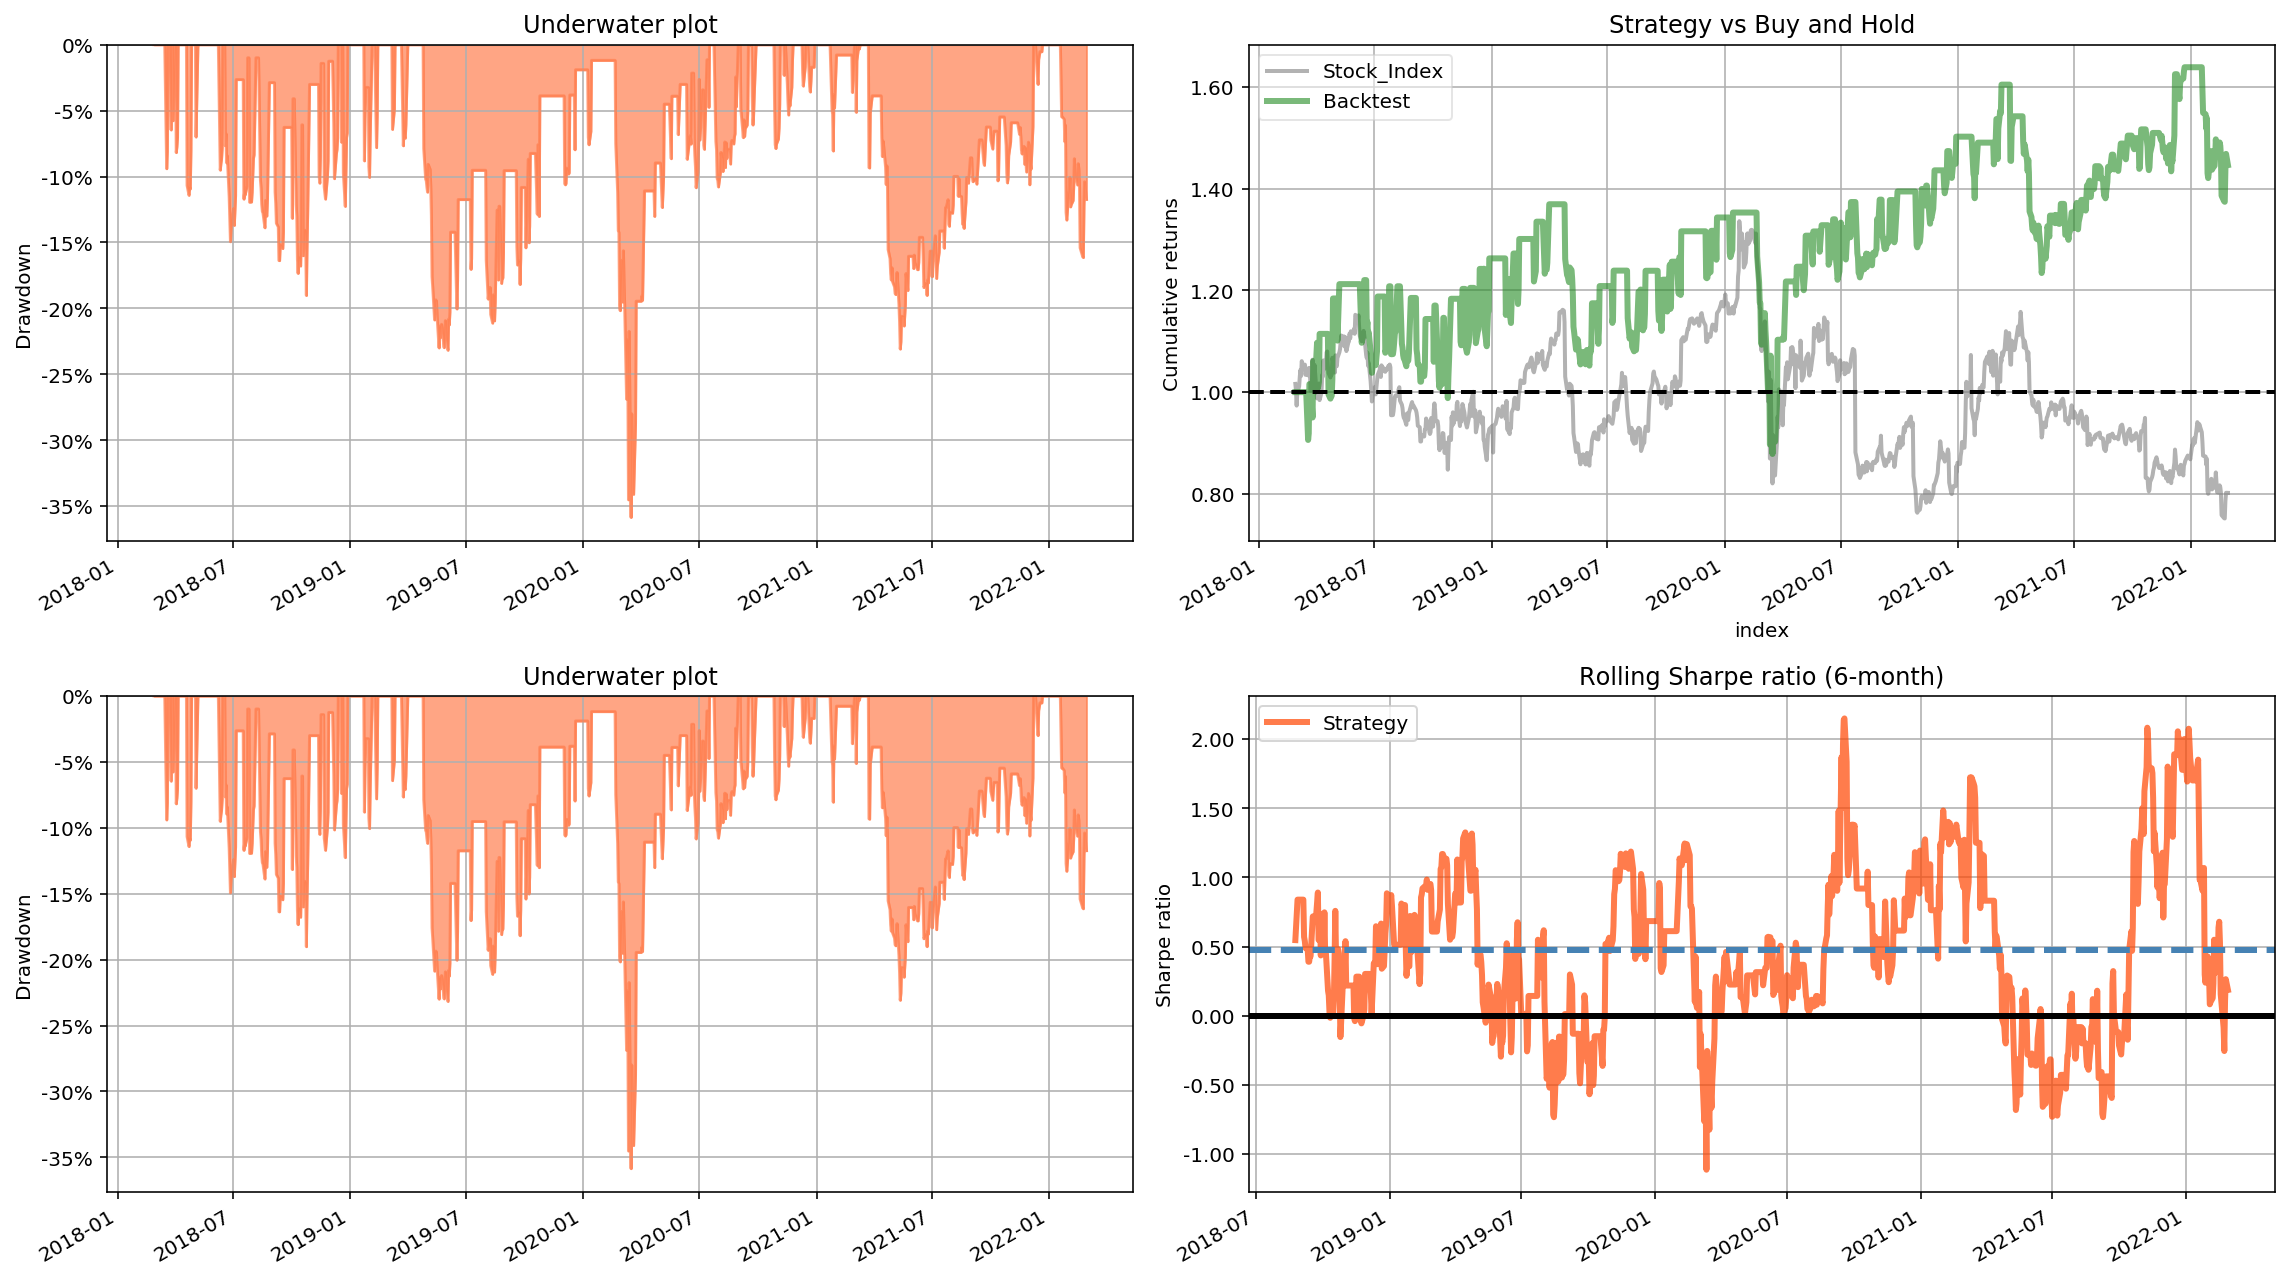

In [144]:
# plot performance for strategy vs benchmark
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 9),constrained_layout=True)
axes = ax.flatten()

#pf.plot_drawdown_periods(returns=returns, ax=axes[0])
pf.plot_drawdown_underwater(returns=returns, ax=axes[0])
axes[0].grid(True)
pf.plot_rolling_returns(returns=returns,
                        factor_returns=benchmark_rets,
                        ax=axes[1], title='Strategy vs Buy and Hold')
axes[1].grid(True)
pf.plot_drawdown_underwater(returns=returns, ax=axes[2])
axes[2].grid(True)
pf.plot_rolling_sharpe(returns=returns, ax=axes[3])
axes[3].grid(True)
# fig.suptitle('XXX', fontsize=16, y=0.990)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('images/chart3', dpi=300)

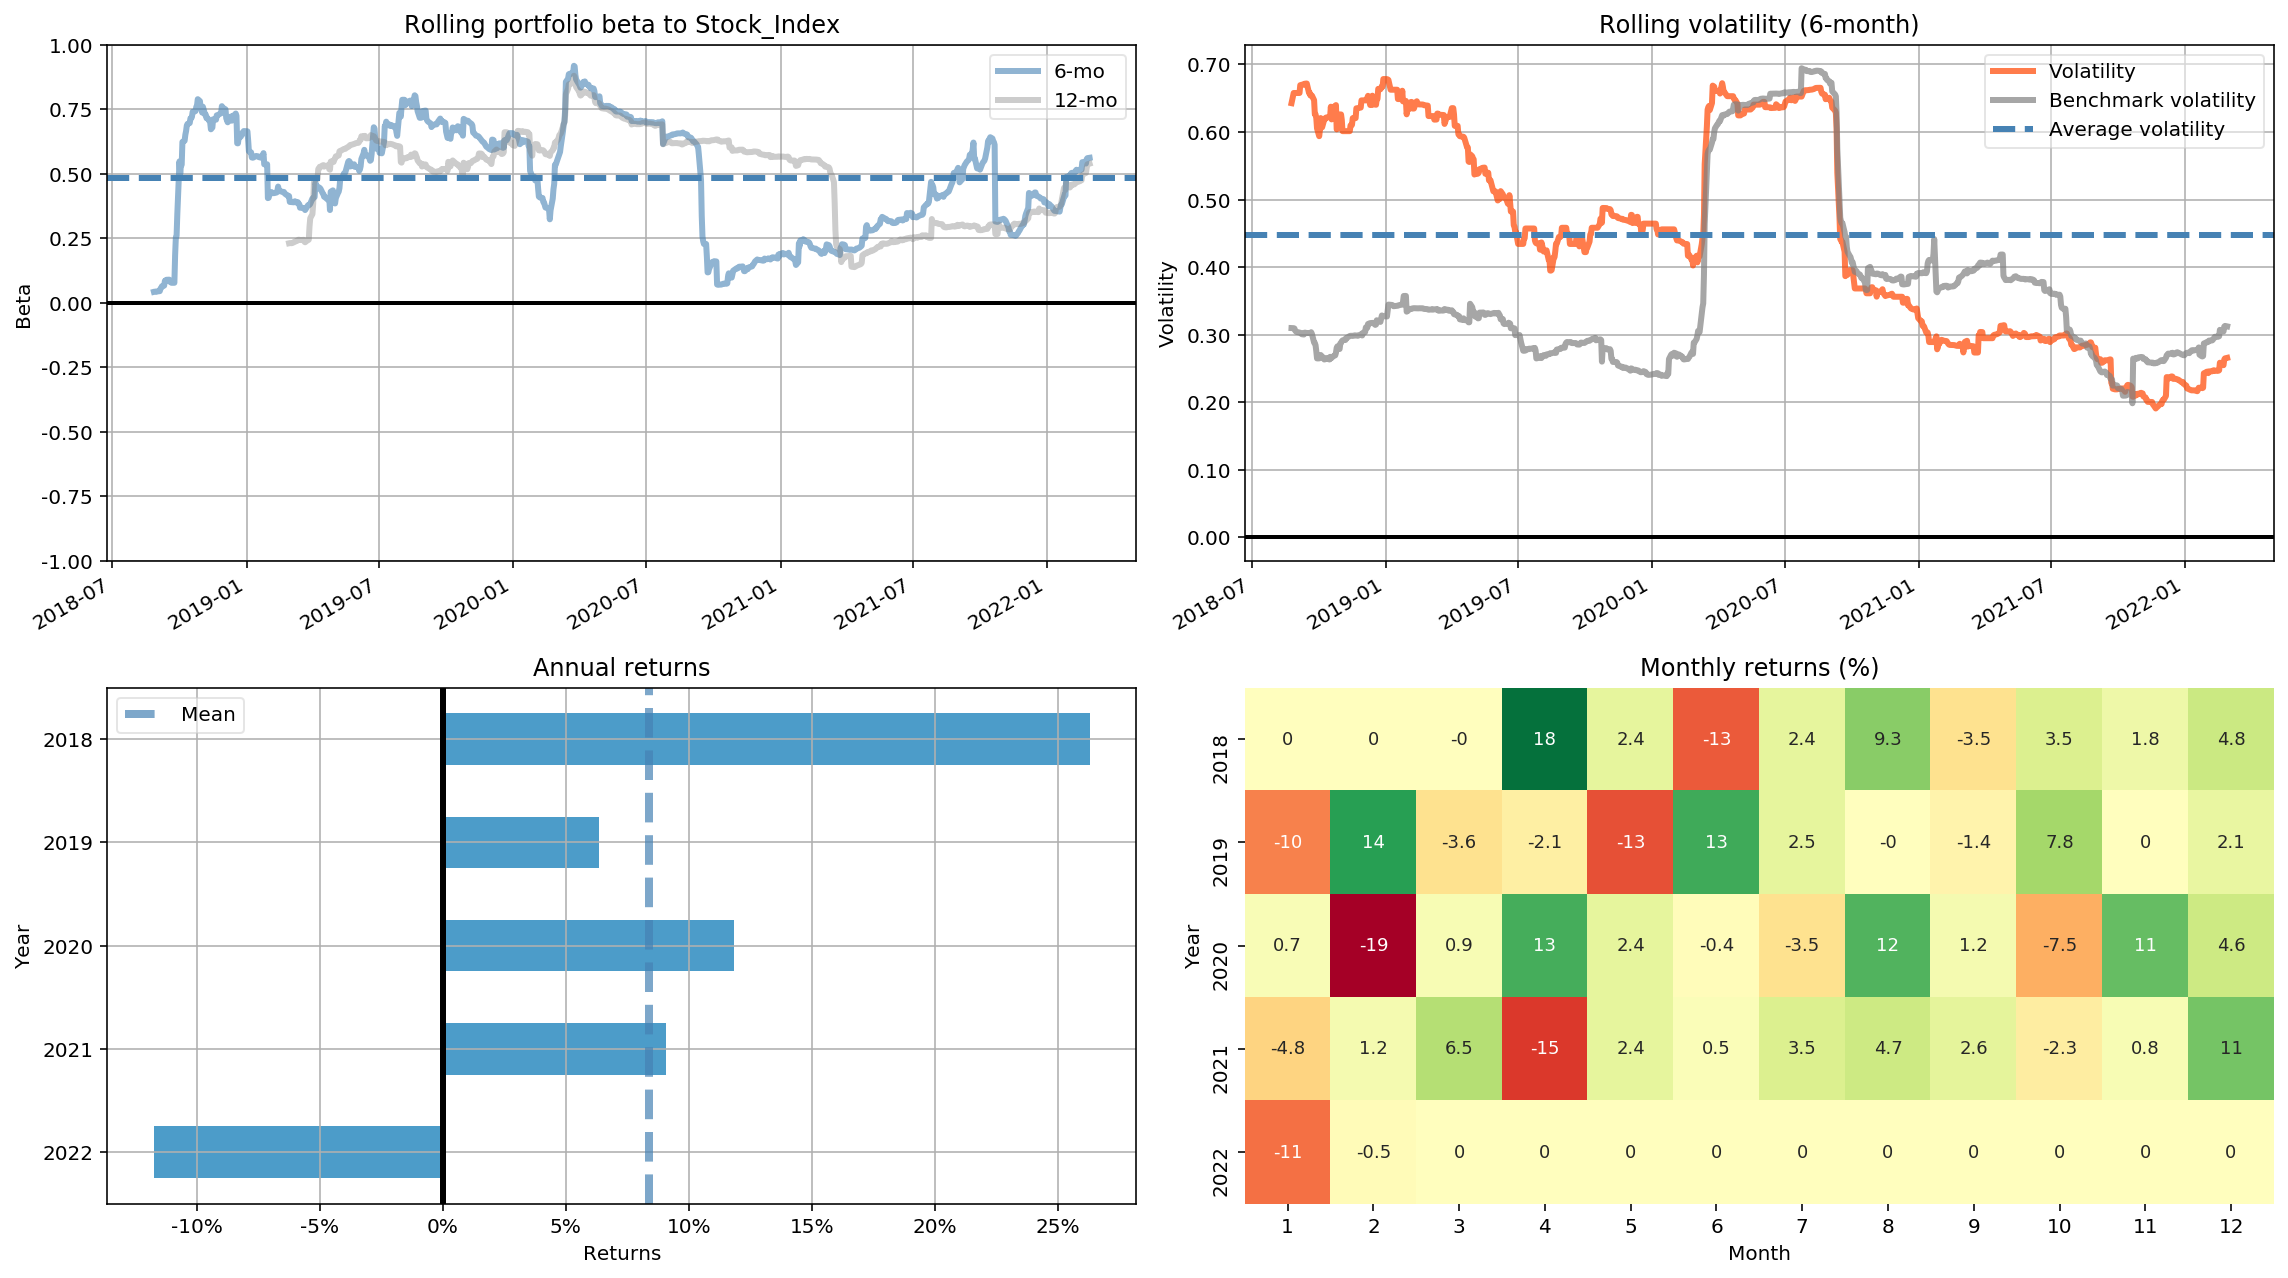

In [145]:
# plot performance for strategy vs benchmark
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 9),constrained_layout=True)
axes = ax.flatten()

pf.plot_rolling_beta(returns=returns, factor_returns=benchmark_rets, ax=axes[0])
axes[0].grid(True)

pf.plot_rolling_volatility(returns=returns, factor_returns=benchmark_rets,ax=axes[1])
axes[1].grid(True)

pf.plot_annual_returns(returns=returns, ax=axes[2])
axes[2].grid(True)

pf.plot_monthly_returns_heatmap(returns=returns, ax=axes[3],)
# fig.suptitle('XXX', fontsize=16, y=1.0)


plt.tight_layout()
plt.savefig('images/chart4', dpi=300)